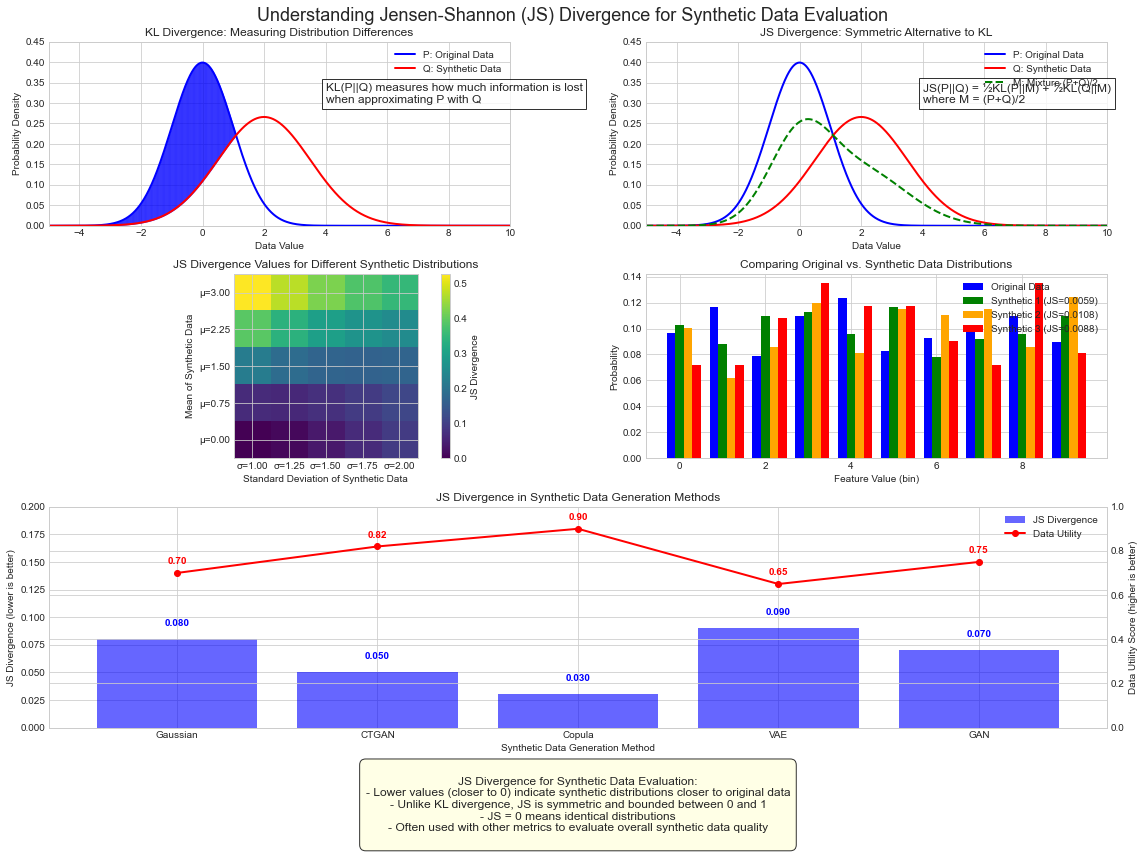

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14})

# Create a figure with multiple subplots
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])

# 1. First subplot: Conceptual explanation with KL divergence
ax1 = plt.subplot(gs[0, 0])

# Create two distributions
x = np.linspace(-5, 10, 1000)
p = stats.norm.pdf(x, 0, 1)  # Distribution P
q = stats.norm.pdf(x, 2, 1.5)  # Distribution Q

# Plot the distributions
ax1.plot(x, p, 'b-', linewidth=2, label='P: Original Data')
ax1.plot(x, q, 'r-', linewidth=2, label='Q: Synthetic Data')
ax1.set_ylim(0, 0.45)
ax1.set_xlim(-5, 10)
ax1.legend(loc='upper right')
ax1.set_title('KL Divergence: Measuring Distribution Differences')
ax1.set_ylabel('Probability Density')
ax1.set_xlabel('Data Value')

# Add explanatory text
kl_text = "KL(P||Q) measures how much information is lost\nwhen approximating P with Q"
ax1.text(4, 0.3, kl_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Add KL area visualization
for i in range(len(x)-1):
    if p[i] > q[i]:
        ax1.fill_between(x[i:i+2], p[i:i+2], q[i:i+2], alpha=0.3, color='blue')

# 2. Second subplot: JS divergence explanation
ax2 = plt.subplot(gs[0, 1])

# Create mixture distribution
m = (p + q) / 2

# Plot the distributions
ax2.plot(x, p, 'b-', linewidth=2, label='P: Original Data')
ax2.plot(x, q, 'r-', linewidth=2, label='Q: Synthetic Data')
ax2.plot(x, m, 'g--', linewidth=2, label='M: Mixture (P+Q)/2')
ax2.set_ylim(0, 0.45)
ax2.set_xlim(-5, 10)
ax2.legend(loc='upper right')
ax2.set_title('JS Divergence: Symmetric Alternative to KL')
ax2.set_ylabel('Probability Density')
ax2.set_xlabel('Data Value')

# Add explanatory text
js_text = "JS(P||Q) = ½KL(P||M) + ½KL(Q||M)\nwhere M = (P+Q)/2"
ax2.text(4, 0.3, js_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 3. Third subplot: Visualizing JS divergence values
ax3 = plt.subplot(gs[1, 0])

# Create a range of synthetic distributions with varying means and stds
means = np.linspace(0, 3, 5)
stds = np.linspace(1, 2, 5)

js_values = np.zeros((len(means), len(stds)))

# Calculate JS divergence
for i, mean in enumerate(means):
    for j, std in enumerate(stds):
        q_temp = stats.norm.pdf(x, mean, std)
        m_temp = (p + q_temp) / 2
        kl_p_m = np.sum(np.where(p > 0, p * np.log(p / m_temp), 0)) * (x[1] - x[0])
        kl_q_m = np.sum(np.where(q_temp > 0, q_temp * np.log(q_temp / m_temp), 0)) * (x[1] - x[0])
        js_values[i, j] = 0.5 * kl_p_m + 0.5 * kl_q_m

# Create heatmap
im = ax3.imshow(js_values, cmap='viridis', origin='lower')
plt.colorbar(im, ax=ax3, label='JS Divergence')
ax3.set_xticks(np.arange(len(stds)))
ax3.set_yticks(np.arange(len(means)))
ax3.set_xticklabels([f'σ={std:.2f}' for std in stds])
ax3.set_yticklabels([f'μ={mean:.2f}' for mean in means])
ax3.set_title('JS Divergence Values for Different Synthetic Distributions')
ax3.set_xlabel('Standard Deviation of Synthetic Data')
ax3.set_ylabel('Mean of Synthetic Data')

# 4. Fourth subplot: Real data example
ax4 = plt.subplot(gs[1, 1])

# Simulate binned data (like histograms)
np.random.seed(42)
bins = np.arange(10)
original_counts = np.random.poisson(lam=30, size=10)
original_probs = original_counts / original_counts.sum()

# Create three different synthetic datasets
synthetic1 = np.random.poisson(lam=30, size=10)
synthetic1_probs = synthetic1 / synthetic1.sum()

synthetic2 = np.random.poisson(lam=20, size=10)
synthetic2_probs = synthetic2 / synthetic2.sum()

synthetic3 = np.random.poisson(lam=10, size=10)
synthetic3_probs = synthetic3 / synthetic3.sum()

# Calculate JS divergence for each synthetic dataset
def calculate_js(p, q):
    m = (p + q) / 2
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    m = m + epsilon
    
    # Normalize again
    p = p / p.sum()
    q = q / q.sum()
    m = m / m.sum()
    
    kl_p_m = np.sum(p * np.log(p / m))
    kl_q_m = np.sum(q * np.log(q / m))
    return 0.5 * kl_p_m + 0.5 * kl_q_m

js1 = calculate_js(original_probs, synthetic1_probs)
js2 = calculate_js(original_probs, synthetic2_probs)
js3 = calculate_js(original_probs, synthetic3_probs)

# Bar chart
width = 0.2
ax4.bar(bins - width, original_probs, width, label='Original Data', color='blue')
ax4.bar(bins, synthetic1_probs, width, label=f'Synthetic 1 (JS={js1:.4f})', color='green')
ax4.bar(bins + width, synthetic2_probs, width, label=f'Synthetic 2 (JS={js2:.4f})', color='orange')
ax4.bar(bins + 2*width, synthetic3_probs, width, label=f'Synthetic 3 (JS={js3:.4f})', color='red')
ax4.set_xlabel('Feature Value (bin)')
ax4.set_ylabel('Probability')
ax4.set_title('Comparing Original vs. Synthetic Data Distributions')
ax4.legend(loc='upper right')

# 5. Fifth subplot (spans two columns): JS Divergence in the context of synthetic data evaluation
ax5 = plt.subplot(gs[2, :])

# Create a comparison of different metrics
methods = ['Gaussian', 'CTGAN', 'Copula', 'VAE', 'GAN']
js_scores = [0.08, 0.05, 0.03, 0.09, 0.07]
other_metric = [0.7, 0.82, 0.9, 0.65, 0.75]  # Could be some other quality metric

# Twin axes for comparing metrics
ax5a = ax5
ax5a.set_xlabel('Synthetic Data Generation Method')
ax5a.set_ylabel('JS Divergence (lower is better)')
ax5a.bar(methods, js_scores, color='blue', alpha=0.6, label='JS Divergence')
ax5a.set_ylim(0, 0.2)

ax5b = ax5a.twinx()
ax5b.set_ylabel('Data Utility Score (higher is better)')
ax5b.plot(methods, other_metric, 'ro-', linewidth=2, label='Data Utility')
ax5b.set_ylim(0, 1.0)

# Add annotations
for i, method in enumerate(methods):
    ax5a.annotate(f"{js_scores[i]:.3f}", 
                 xy=(i, js_scores[i] + 0.01), 
                 ha='center', va='bottom', 
                 color='blue', fontweight='bold')
    
    ax5b.annotate(f"{other_metric[i]:.2f}", 
                 xy=(i, other_metric[i] + 0.03), 
                 ha='center', va='bottom', 
                 color='red', fontweight='bold')

# Add explanation
explanation = """
JS Divergence for Synthetic Data Evaluation:
- Lower values (closer to 0) indicate synthetic distributions closer to original data
- Unlike KL divergence, JS is symmetric and bounded between 0 and 1
- JS = 0 means identical distributions
- Often used with other metrics to evaluate overall synthetic data quality
"""
ax5.text(0.5, -0.35, explanation, transform=ax5.transAxes, 
        ha='center', va='center', fontsize=12,
        bbox=dict(facecolor='lightyellow', alpha=0.8, boxstyle='round,pad=0.5'))

# Combine legends
lines1, labels1 = ax5a.get_legend_handles_labels()
lines2, labels2 = ax5b.get_legend_handles_labels()
ax5.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax5a.set_title('JS Divergence in Synthetic Data Generation Methods')

# Adjust layout
plt.tight_layout()
fig.suptitle('Understanding Jensen-Shannon (JS) Divergence for Synthetic Data Evaluation', 
             fontsize=18, y=0.98)
fig.subplots_adjust(top=0.94)

# Save the figure
plt.savefig('js_divergence_explanation.png', dpi=300, bbox_inches='tight')
plt.show()


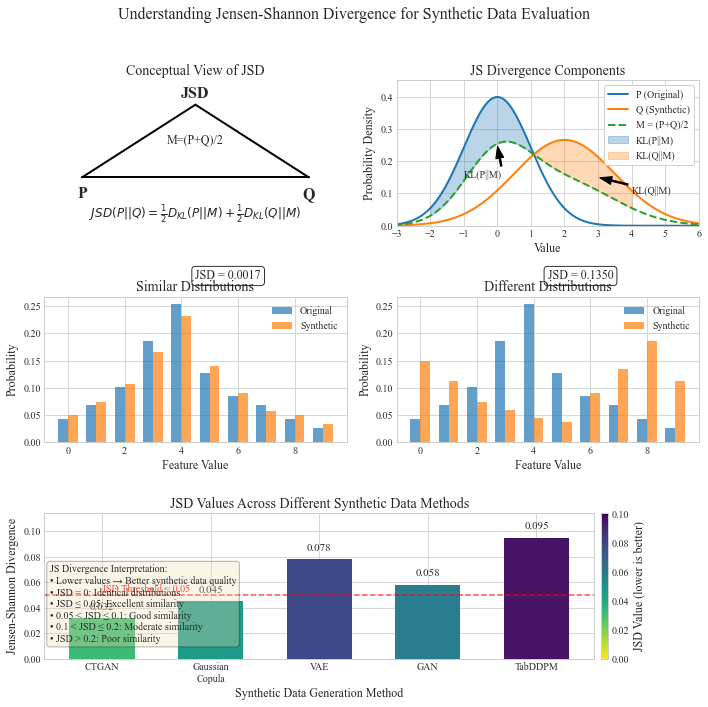

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon, FancyArrowPatch
import matplotlib as mpl

# Set clean publication style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Create a figure with grid layout
fig = plt.figure(figsize=(10, 10), facecolor='white')
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

# Define colors for visualizations
colors = {
    'P': '#1f77b4',  # blue
    'Q': '#ff7f0e',  # orange
    'M': '#2ca02c',  # green
    'JSD': '#d62728',  # red
    'KL': '#9467bd'   # purple
}

# 1. Top Left Panel: Conceptual Diagram of JS Divergence
ax1 = plt.subplot(gs[0, 0])

# Draw conceptual diagram - triangle representation
ax1.plot([-3, 3], [0, 0], 'k-', lw=2)  # Horizontal line
ax1.plot([-3, 0], [0, 3], 'k-', lw=2)  # Left diagonal
ax1.plot([3, 0], [0, 3], 'k-', lw=2)   # Right diagonal

# Add labels
ax1.text(-3, -0.4, 'P', fontsize=16, ha='center', va='top', fontweight='bold')
ax1.text(3, -0.4, 'Q', fontsize=16, ha='center', va='top', fontweight='bold')
ax1.text(0, 3.1, 'JSD', fontsize=16, ha='center', va='bottom', fontweight='bold')
ax1.text(0, 1.5, 'M=(P+Q)/2', fontsize=12, ha='center', va='center')

# Add formula
ax1.text(0, -1.5, r'$JSD(P||Q) = \frac{1}{2}D_{KL}(P||M) + \frac{1}{2}D_{KL}(Q||M)$', 
         fontsize=12, ha='center', va='center')

ax1.set_xlim(-4, 4)
ax1.set_ylim(-2, 4)
ax1.set_title('Conceptual View of JSD')
ax1.axis('off')

# 2. Top Right Panel: Visual comparison of probability distributions
ax2 = plt.subplot(gs[0, 1])

# Create x values
x = np.linspace(-4, 8, 1000)

# Define two distributions
p_dist = stats.norm.pdf(x, 0, 1)  # Distribution P - original data
q_dist = stats.norm.pdf(x, 2, 1.5)  # Distribution Q - synthetic data
m_dist = (p_dist + q_dist) / 2  # Mixture distribution M

# Plot distributions
ax2.plot(x, p_dist, '-', color=colors['P'], lw=2, label='P (Original)')
ax2.plot(x, q_dist, '-', color=colors['Q'], lw=2, label='Q (Synthetic)')
ax2.plot(x, m_dist, '--', color=colors['M'], lw=2, label='M = (P+Q)/2')

# Shade regions to illustrate divergence
x_idx = np.logical_and(x >= -2, x <= 4)
x_sub = x[x_idx]
p_sub = p_dist[x_idx]
q_sub = q_dist[x_idx]
m_sub = m_dist[x_idx]

# KL(P||M) shading
kl_p_idx = np.logical_and(x_sub >= -2, x_sub <= 1)
ax2.fill_between(x_sub[kl_p_idx], p_sub[kl_p_idx], m_sub[kl_p_idx], 
                 color=colors['P'], alpha=0.3, label='KL(P||M)')

# KL(Q||M) shading
kl_q_idx = np.logical_and(x_sub >= 1, x_sub <= 4)
ax2.fill_between(x_sub[kl_q_idx], q_sub[kl_q_idx], m_sub[kl_q_idx], 
                 color=colors['Q'], alpha=0.3, label='KL(Q||M)')

# Add annotations
ax2.annotate('KL(P||M)', xy=(0, 0.25), xytext=(-1, 0.15),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=10)

ax2.annotate('KL(Q||M)', xy=(3, 0.15), xytext=(4, 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=10)

ax2.set_xlim(-3, 6)
ax2.set_ylim(0, 0.45)
ax2.set_xlabel('Value')
ax2.set_ylabel('Probability Density')
ax2.set_title('JS Divergence Components')
ax2.legend(loc='upper right', frameon=True, framealpha=0.9)

# 3. Middle Left Panel: Histogram comparison - similar distributions
ax3 = plt.subplot(gs[1, 0])

# Create similar histograms
bins = np.arange(10)
np.random.seed(42)
original = np.array([5, 8, 12, 22, 30, 15, 10, 8, 5, 3])
original_probs = original / original.sum()

# Create a "similar" synthetic dataset
synthetic_similar = np.array([6, 9, 13, 20, 28, 17, 11, 7, 6, 4])
synthetic_similar_probs = synthetic_similar / synthetic_similar.sum()

# Calculate JS Divergence
def js_divergence(p, q):
    m = (p + q) / 2
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    p_safe = p + epsilon
    q_safe = q + epsilon
    m_safe = m + epsilon
    
    # Normalize
    p_safe = p_safe / p_safe.sum()
    q_safe = q_safe / q_safe.sum()
    m_safe = m_safe / m_safe.sum()
    
    kl_p_m = np.sum(p_safe * np.log(p_safe / m_safe))
    kl_q_m = np.sum(q_safe * np.log(q_safe / m_safe))
    return 0.5 * kl_p_m + 0.5 * kl_q_m

js_similar = js_divergence(original_probs, synthetic_similar_probs)

# Bar width
width = 0.35

# Plot histograms
ax3.bar(bins - width/2, original_probs, width, color=colors['P'], alpha=0.7, label='Original')
ax3.bar(bins + width/2, synthetic_similar_probs, width, color=colors['Q'], alpha=0.7, label='Synthetic')

# Add JS divergence value
ax3.text(4.5, 0.3, f'JSD = {js_similar:.4f}', fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))

ax3.set_xlabel('Feature Value')
ax3.set_ylabel('Probability')
ax3.set_title('Similar Distributions')
ax3.legend()

# 4. Middle Right Panel: Histogram comparison - different distributions
ax4 = plt.subplot(gs[1, 1])

# Create a "different" synthetic dataset
synthetic_different = np.array([20, 15, 10, 8, 6, 5, 12, 18, 25, 15])
synthetic_different_probs = synthetic_different / synthetic_different.sum()

# Calculate JS Divergence
js_different = js_divergence(original_probs, synthetic_different_probs)

# Plot histograms
ax4.bar(bins - width/2, original_probs, width, color=colors['P'], alpha=0.7, label='Original')
ax4.bar(bins + width/2, synthetic_different_probs, width, color=colors['Q'], alpha=0.7, label='Synthetic')

# Add JS divergence value
ax4.text(4.5, 0.3, f'JSD = {js_different:.4f}', fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))

ax4.set_xlabel('Feature Value')
ax4.set_ylabel('Probability')
ax4.set_title('Different Distributions')
ax4.legend()

# 5. Bottom Panel: JSD values for different synthetic methods
ax5 = plt.subplot(gs[2, :])

# Create example methods and their JSD values
methods = ['CTGAN', 'Gaussian\nCopula', 'VAE', 'GAN', 'TabDDPM']
jsd_values = [0.032, 0.045, 0.078, 0.058, 0.095]

# Configure a colormap to visualize JSD values
norm = mpl.colors.Normalize(vmin=0, vmax=0.1)
cmap = mpl.cm.viridis_r
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot bars with color based on JSD
bars = ax5.bar(methods, jsd_values, color=cmap(norm(jsd_values)), width=0.6)

# Add value labels above bars
for bar, value in zip(bars, jsd_values):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{value:.3f}', ha='center', va='bottom', fontsize=11)

# Add horizontal line for reference
ax5.axhline(y=0.05, linestyle='--', color='red', alpha=0.7)
ax5.text(0, 0.052, 'JSD Threshold = 0.05', color='red', fontsize=10)

# Add interpretation explanation
properties = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
explanation = (
    "JS Divergence Interpretation:\n"
    "• Lower values → Better synthetic data quality\n"
    "• JSD = 0: Identical distributions\n"
    "• JSD ≤ 0.05: Excellent similarity\n"
    "• 0.05 < JSD ≤ 0.1: Good similarity\n"
    "• 0.1 < JSD ≤ 0.2: Moderate similarity\n"
    "• JSD > 0.2: Poor similarity"
)
ax5.text(0.01, 0.65, explanation, transform=ax5.transAxes, fontsize=10,
        verticalalignment='top', bbox=properties)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax5, pad=0.01)
cbar.set_label('JSD Value (lower is better)')

ax5.set_xlabel('Synthetic Data Generation Method')
ax5.set_ylabel('Jensen-Shannon Divergence')
ax5.set_title('JSD Values Across Different Synthetic Data Methods')
ax5.set_ylim(0, max(jsd_values) * 1.2)

# Main title for the figure
fig.suptitle('Understanding Jensen-Shannon Divergence for Synthetic Data Evaluation', 
             fontsize=16, y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('jensen_shannon_divergence_explanation.png', dpi=300, bbox_inches='tight')
plt.show()

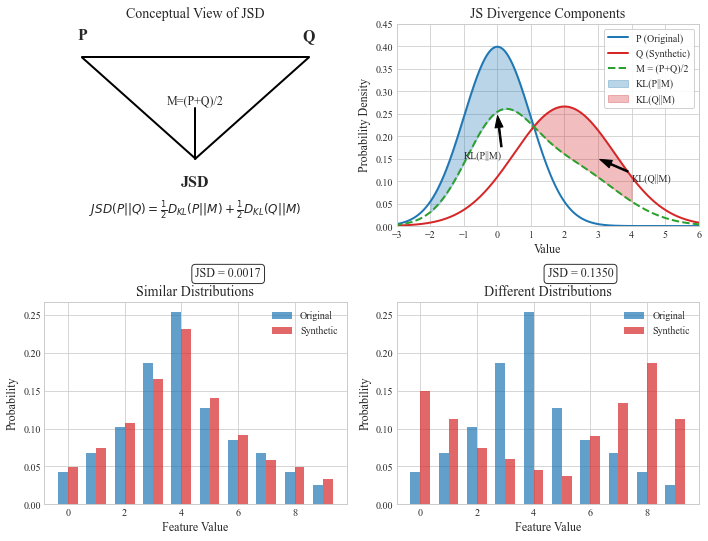

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.gridspec as gridspec
import matplotlib as mpl

# Set clean publication style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Create a figure with grid layout (2x2 layout)
fig = plt.figure(figsize=(10, 8), facecolor='white')
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Define colors for visualizations
colors = {
    'P': '#1f77b4',  # blue
    'Q': '#d62728',  # orange
    # 'Q': '#d62728',  # orange
    # 'Q': '#ff7f0e',  # orange
    'M': '#2ca02c',  # green
    'JSD': '#d62728',  # red
    'KL': '#9467bd'   # purple
}

# 1. Top Left Panel: Conceptual Diagram of JS Divergence (inverted triangle - balance)
ax1 = plt.subplot(gs[0, 0])

# Draw conceptual diagram - inverted triangle (balance) representation
ax1.plot([-3, 3], [3, 3], 'k-', lw=2)  # Horizontal line on top
ax1.plot([-3, 0], [3, 0], 'k-', lw=2)  # Left diagonal
ax1.plot([3, 0], [3, 0], 'k-', lw=2)   # Right diagonal

# Add center line
ax1.plot([0, 0], [0, 1.5], 'k-', lw=2)  # Vertical line (balance stem)

# Add labels
ax1.text(-3, 3.4, 'P', fontsize=16, ha='center', va='bottom', fontweight='bold')
ax1.text(3, 3.4, 'Q', fontsize=16, ha='center', va='bottom', fontweight='bold')
ax1.text(0, -0.5, 'JSD', fontsize=16, ha='center', va='top', fontweight='bold')
ax1.text(0, 1.7, 'M=(P+Q)/2', fontsize=12, ha='center', va='center')

# Add formula
ax1.text(0, -1.5, r'$JSD(P||Q) = \frac{1}{2}D_{KL}(P||M) + \frac{1}{2}D_{KL}(Q||M)$', 
         fontsize=12, ha='center', va='center')

ax1.set_xlim(-4, 4)
ax1.set_ylim(-2, 4)
ax1.set_title('Conceptual View of JSD')
ax1.axis('off')

# 2. Top Right Panel: Visual comparison of probability distributions
ax2 = plt.subplot(gs[0, 1])

# Create x values
x = np.linspace(-4, 8, 1000)

# Define two distributions
p_dist = stats.norm.pdf(x, 0, 1)  # Distribution P - original data
q_dist = stats.norm.pdf(x, 2, 1.5)  # Distribution Q - synthetic data
m_dist = (p_dist + q_dist) / 2  # Mixture distribution M

# Plot distributions
ax2.plot(x, p_dist, '-', color=colors['P'], lw=2, label='P (Original)')
ax2.plot(x, q_dist, '-', color=colors['Q'], lw=2, label='Q (Synthetic)')
ax2.plot(x, m_dist, '--', color=colors['M'], lw=2, label='M = (P+Q)/2')

# Shade regions to illustrate divergence
x_idx = np.logical_and(x >= -2, x <= 4)
x_sub = x[x_idx]
p_sub = p_dist[x_idx]
q_sub = q_dist[x_idx]
m_sub = m_dist[x_idx]

# KL(P||M) shading
kl_p_idx = np.logical_and(x_sub >= -2, x_sub <= 1)
ax2.fill_between(x_sub[kl_p_idx], p_sub[kl_p_idx], m_sub[kl_p_idx], 
                 color=colors['P'], alpha=0.3, label='KL(P||M)')

# KL(Q||M) shading
kl_q_idx = np.logical_and(x_sub >= 1, x_sub <= 4)
ax2.fill_between(x_sub[kl_q_idx], q_sub[kl_q_idx], m_sub[kl_q_idx], 
                 color=colors['Q'], alpha=0.3, label='KL(Q||M)')

# Add annotations
ax2.annotate('KL(P||M)', xy=(0, 0.25), xytext=(-1, 0.15),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=10)

ax2.annotate('KL(Q||M)', xy=(3, 0.15), xytext=(4, 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=10)

ax2.set_xlim(-3, 6)
ax2.set_ylim(0, 0.45)
ax2.set_xlabel('Value')
ax2.set_ylabel('Probability Density')
ax2.set_title('JS Divergence Components')
ax2.legend(loc='upper right', frameon=True, framealpha=0.9)

# 3. Bottom Left Panel: Histogram comparison - similar distributions
ax3 = plt.subplot(gs[1, 0])

# Create similar histograms
bins = np.arange(10)
np.random.seed(42)
original = np.array([5, 8, 12, 22, 30, 15, 10, 8, 5, 3])
original_probs = original / original.sum()

# Create a "similar" synthetic dataset
synthetic_similar = np.array([6, 9, 13, 20, 28, 17, 11, 7, 6, 4])
synthetic_similar_probs = synthetic_similar / synthetic_similar.sum()

# Calculate JS Divergence
def js_divergence(p, q):
    m = (p + q) / 2
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    p_safe = p + epsilon
    q_safe = q + epsilon
    m_safe = m + epsilon
    
    # Normalize
    p_safe = p_safe / p_safe.sum()
    q_safe = q_safe / q_safe.sum()
    m_safe = m_safe / m_safe.sum()
    
    kl_p_m = np.sum(p_safe * np.log(p_safe / m_safe))
    kl_q_m = np.sum(q_safe * np.log(q_safe / m_safe))
    return 0.5 * kl_p_m + 0.5 * kl_q_m

js_similar = js_divergence(original_probs, synthetic_similar_probs)

# Bar width
width = 0.35

# Plot histograms
ax3.bar(bins - width/2, original_probs, width, color=colors['P'], alpha=0.7, label='Original')
ax3.bar(bins + width/2, synthetic_similar_probs, width, color=colors['Q'], alpha=0.7, label='Synthetic')

# Add JS divergence value
ax3.text(4.5, 0.3, f'JSD = {js_similar:.4f}', fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))

ax3.set_xlabel('Feature Value')
ax3.set_ylabel('Probability')
ax3.set_title('Similar Distributions')
ax3.legend()

# 4. Bottom Right Panel: Histogram comparison - different distributions
ax4 = plt.subplot(gs[1, 1])

# Create a "different" synthetic dataset
synthetic_different = np.array([20, 15, 10, 8, 6, 5, 12, 18, 25, 15])
synthetic_different_probs = synthetic_different / synthetic_different.sum()

# Calculate JS Divergence
js_different = js_divergence(original_probs, synthetic_different_probs)

# Plot histograms
ax4.bar(bins - width/2, original_probs, width, color=colors['P'], alpha=0.7, label='Original')
ax4.bar(bins + width/2, synthetic_different_probs, width, color=colors['Q'], alpha=0.7, label='Synthetic')

# Add JS divergence value
ax4.text(4.5, 0.3, f'JSD = {js_different:.4f}', fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))

ax4.set_xlabel('Feature Value')
ax4.set_ylabel('Probability')
ax4.set_title('Different Distributions')
ax4.legend()

# Main title for the figure
# fig.suptitle('Understanding Jensen-Shannon Divergence for Synthetic Data Evaluation', 
#              fontsize=16, y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.96])

# # Add interpretation note at the bottom of the figure
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
# interpretation = (
#     "JS Divergence Interpretation:\n"
#     "• JSD = 0: Identical distributions\n"
#     "• JSD ≤ 0.05: Excellent similarity\n"
#     "• 0.05 < JSD ≤ 0.1: Good similarity\n"
#     "• JSD > 0.1: Poor similarity"
# )
# fig.text(0.5, 0.02, interpretation, fontsize=10, 
#          ha='center', va='center', bbox=props)

# Save the figure
plt.savefig('jensen_shannon_divergence_explanation.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\shanb\AppData\Local\Temp\ipykernel_47676\3303626711.py:150: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax3.plot([A[0], C[0]], [A[1], C[1]], 'k-', lw=1.5, linestyle='--')


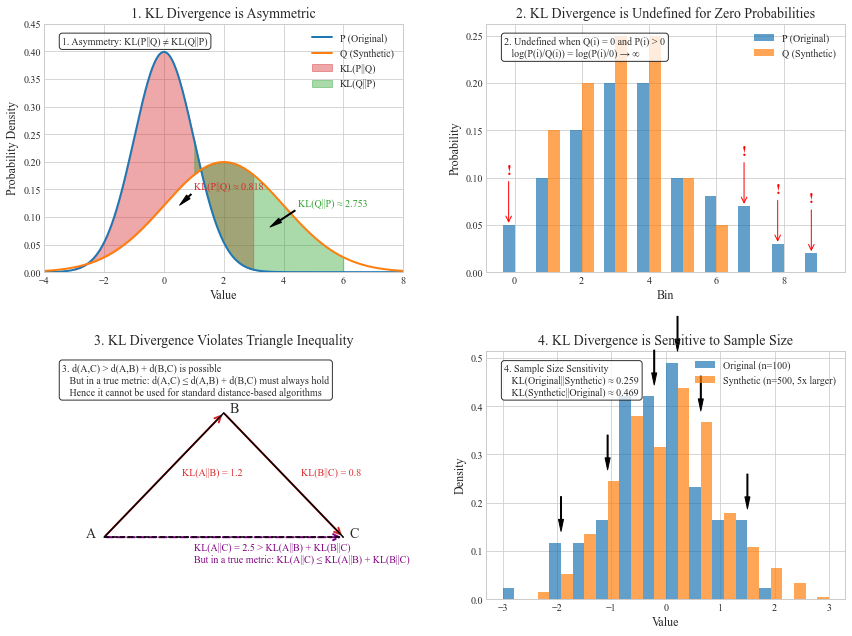

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle, FancyArrowPatch
import matplotlib as mpl

# Set clean publication style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Create figure with grid layout
fig = plt.figure(figsize=(12, 10), facecolor='white')
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Define colors
colors = {
    'P': '#1f77b4',  # blue
    'Q': '#ff7f0e',  # orange
    'KL_PQ': '#d62728',  # red
    'KL_QP': '#2ca02c',  # green
}

# =============================================================
# Panel 1: Asymmetry of KL Divergence
# =============================================================
ax1 = plt.subplot(gs[0, 0])

# Create data for two distributions
x = np.linspace(-6, 10, 1000)
p_dist = stats.norm.pdf(x, 0, 1)  # Distribution P
q_dist = stats.norm.pdf(x, 2, 2)  # Distribution Q (different mean and variance)

# Plot the distributions
ax1.plot(x, p_dist, '-', color=colors['P'], lw=2, label='P (Original)')
ax1.plot(x, q_dist, '-', color=colors['Q'], lw=2, label='Q (Synthetic)')

# Calculate KL divergence areas (simplified representation)
kl_pq_indices = np.logical_and(x >= -3, x <= 3)
kl_qp_indices = np.logical_and(x >= 1, x <= 6)

# Shade areas representing the divergences
ax1.fill_between(x[kl_pq_indices], p_dist[kl_pq_indices], q_dist[kl_pq_indices], 
                 color=colors['KL_PQ'], alpha=0.4, label='KL(P||Q)')
ax1.fill_between(x[kl_qp_indices], q_dist[kl_qp_indices], p_dist[kl_qp_indices], 
                 color=colors['KL_QP'], alpha=0.4, label='KL(Q||P)')

# Calculate actual KL divergence (approximate)
def kl_divergence(p, q, dx):
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    p_safe = p + epsilon
    q_safe = q + epsilon
    
    # Calculate KL divergence
    return np.sum(p_safe * np.log(p_safe / q_safe)) * dx

dx = x[1] - x[0]
kl_pq = kl_divergence(p_dist, q_dist, dx)
kl_qp = kl_divergence(q_dist, p_dist, dx)

# Add annotations
ax1.annotate(f'KL(P||Q) ≈ {kl_pq:.3f}', xy=(0.5, 0.12), xytext=(1, 0.15),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
             fontsize=10, color=colors['KL_PQ'])

ax1.annotate(f'KL(Q||P) ≈ {kl_qp:.3f}', xy=(3.5, 0.08), xytext=(4.5, 0.12),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
             fontsize=10, color=colors['KL_QP'])

# Add note about asymmetry
note = "1. Asymmetry: KL(P||Q) ≠ KL(Q||P)"
ax1.text(0.05, 0.95, note, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax1.set_xlim(-4, 8)
ax1.set_ylim(0, 0.45)
ax1.set_xlabel('Value')
ax1.set_ylabel('Probability Density')
ax1.set_title('1. KL Divergence is Asymmetric')
ax1.legend(loc='upper right')

# =============================================================
# Panel 2: Undefined when Q(i) = 0 and P(i) > 0
# =============================================================
ax2 = plt.subplot(gs[0, 1])

# Create discrete distributions
bins = np.arange(10)
width = 0.35

# Create P with non-zero values everywhere
p_values = np.array([0.05, 0.1, 0.15, 0.2, 0.2, 0.1, 0.08, 0.07, 0.03, 0.02])

# Create Q with zero in some bins where P is non-zero
q_values = np.array([0.0, 0.15, 0.2, 0.25, 0.25, 0.1, 0.05, 0.0, 0.0, 0.0])

# Plot discrete distributions
ax2.bar(bins - width/2, p_values, width, color=colors['P'], alpha=0.7, label='P (Original)')
ax2.bar(bins + width/2, q_values, width, color=colors['Q'], alpha=0.7, label='Q (Synthetic)')

# Mark problematic areas
for i in range(len(bins)):
    if q_values[i] == 0 and p_values[i] > 0:
        ax2.annotate('!', xy=(bins[i] - width/2, p_values[i]), 
                     xytext=(bins[i] - width/2, p_values[i] + 0.05),
                     fontsize=14, color='red', weight='bold',
                     ha='center', va='bottom',
                     arrowprops=dict(arrowstyle="->", color='red'))
        
# Add explanation
note = "2. Undefined when Q(i) = 0 and P(i) > 0\n   log(P(i)/Q(i)) = log(P(i)/0) → ∞"
ax2.text(0.05, 0.95, note, transform=ax2.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add KL formula
# ax2.text(0.5, 0.7, r'$D_{KL}(P||Q) = \sum_i P(i) \log\frac{P(i)}{Q(i)}$', transform=ax2.transAxes, 
#          fontsize=12, ha='center', color='black',
#          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.set_xlabel('Bin')
ax2.set_ylabel('Probability')
ax2.set_title('2. KL Divergence is Undefined for Zero Probabilities')
ax2.legend()

# =============================================================
# Panel 3: Not a true metric (triangle inequality)
# =============================================================
ax3 = plt.subplot(gs[1, 0])

# Create a visualization of the triangle inequality
# Create a triangle shape to show the violation
# Set up coordinates for points
A = np.array([1, 1])  # Distribution A
B = np.array([3, 3])  # Distribution B 
C = np.array([5, 1])  # Distribution C

# Draw the triangle
ax3.plot([A[0], B[0]], [A[1], B[1]], 'k-', lw=1.5)
ax3.plot([B[0], C[0]], [B[1], C[1]], 'k-', lw=1.5)
ax3.plot([A[0], C[0]], [A[1], C[1]], 'k-', lw=1.5, linestyle='--')

# Add arrows to represent directed KL divergence
arrow_kl_ab = FancyArrowPatch(A, B, arrowstyle='->', mutation_scale=15, 
                            color=colors['KL_PQ'], linewidth=2, label='KL(A||B)')
arrow_kl_bc = FancyArrowPatch(B, C, arrowstyle='->', mutation_scale=15, 
                            color=colors['KL_PQ'], linewidth=2, label='KL(B||C)')
arrow_kl_ac = FancyArrowPatch(A, C, arrowstyle='->', mutation_scale=15, 
                            color='purple', linewidth=2, linestyle='--', label='KL(A||C)')

ax3.add_patch(arrow_kl_ab)
ax3.add_patch(arrow_kl_bc)
ax3.add_patch(arrow_kl_ac)

# Label the points
ax3.text(A[0]-0.3, A[1], 'A', fontsize=14)
ax3.text(B[0]+0.1, B[1], 'B', fontsize=14)
ax3.text(C[0]+0.1, C[1], 'C', fontsize=14)

# Add value labels for the divergences
ax3.text((A[0]+B[0])/2 + 0.3, (A[1]+B[1])/2, 'KL(A||B) = 1.2', 
         color=colors['KL_PQ'], fontsize=10)
ax3.text((B[0]+C[0])/2 + 0.3, (B[1]+C[1])/2, 'KL(B||C) = 0.8', 
         color=colors['KL_PQ'], fontsize=10)
ax3.text((A[0]+C[0])/2 - 0.5, (A[1]+C[1])/2 - 0.4, 'KL(A||C) = 2.5 > KL(A||B) + KL(B||C)\nBut in a true metric: KL(A||C) ≤ KL(A||B) + KL(B||C)', 
         color='purple', fontsize=10)

# Add explanation
note = "3. d(A,C) > d(A,B) + d(B,C) is possible\n   But in a true metric: d(A,C) ≤ d(A,B) + d(B,C) must always hold\n   Hence it cannot be used for standard distance-based algorithms"
ax3.text(0.05, 0.95, note, transform=ax3.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.set_xlim(0, 6)
ax3.set_ylim(0, 4)
ax3.set_title('3. KL Divergence Violates Triangle Inequality')
ax3.axis('off')

# =============================================================
# Panel 4: Sample size sensitivity
# =============================================================
ax4 = plt.subplot(gs[1, 1])

# Create histogram data for two samples of different sizes
np.random.seed(42)
small_sample = np.random.normal(0, 1, size=100)
large_sample = np.random.normal(0, 1, size=500)  # 5x larger, same distribution

# Calculate histogram information
bins_array = np.linspace(-3, 3, 15)

# Plot original histograms
small_hist, _ = np.histogram(small_sample, bins=bins_array, density=True)
large_hist, _ = np.histogram(large_sample, bins=bins_array, density=True)

# Plot centers of bins
bin_centers = (bins_array[:-1] + bins_array[1:]) / 2
width = bins_array[1] - bins_array[0]

# Plot the histograms as bars
ax4.bar(bin_centers - width/4, small_hist, width=width/2, alpha=0.7, color=colors['P'], 
       label='Original (n=100)')
ax4.bar(bin_centers + width/4, large_hist, width=width/2, alpha=0.7, color=colors['Q'], 
       label='Synthetic (n=500, 5x larger)')

# Calculate KL divergence
kl_small_large = kl_divergence(small_hist, large_hist, width)
kl_large_small = kl_divergence(large_hist, small_hist, width)

# Add annotation arrows pointing to discrepancies
for i in range(len(bin_centers)):
    if abs(small_hist[i] - large_hist[i]) > 0.05:
        ax4.annotate('', xy=(bin_centers[i], max(small_hist[i], large_hist[i]) + 0.02),
                    xytext=(bin_centers[i], max(small_hist[i], large_hist[i]) + 0.1),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

# Add explanation
note = (
    "4. Sample Size Sensitivity\n"
    "   KL(Original||Synthetic) ≈ {:.3f}\n"
    "   KL(Synthetic||Original) ≈ {:.3f}"
).format(kl_small_large, kl_large_small)

ax4.text(0.05, 0.95, note, transform=ax4.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax4.set_xlabel('Value')
ax4.set_ylabel('Density')
ax4.set_title('4. KL Divergence is Sensitive to Sample Size')
ax4.legend()

# Add main title
# fig.suptitle('Limitations of KL Divergence for Synthetic Data Evaluation', fontsize=16, y=0.98)

# Add JS divergence advantage note at the bottom
# props = dict(boxstyle='round', facecolor='#e6f7ff', alpha=0.8)
# advantage_note = (
#     "Advantage of Jensen-Shannon Divergence over KL Divergence:\n"
#     "• Symmetric: JSD(P||Q) = JSD(Q||P)\n"
#     "• Bounded: 0 ≤ JSD ≤ 1 (with log base 2)\n"
#     "• Always defined: Smoothed by using mixture distribution M = (P+Q)/2\n"
#     "• More robust to sample size differences and estimation noise"
# )
# fig.text(0.5, 0.02, advantage_note, fontsize=11, ha='center', va='center', bbox=props)

# Adjust layout
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

# Save the figure
plt.savefig('kl_divergence_limitations.png', dpi=300, bbox_inches='tight')
plt.show()

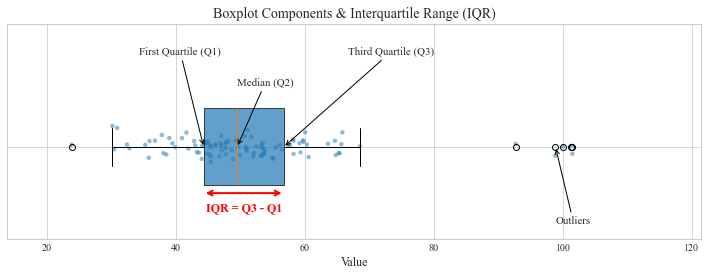

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Create a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Create synthetic data with a clear distribution and outliers
np.random.seed(42)
data = np.concatenate([
    np.random.normal(loc=50, scale=10, size=95),  # Main distribution
    np.random.normal(loc=100, scale=5, size=5)    # Outliers
])

# Create horizontal boxplot
box_elements = ax.boxplot(data, patch_artist=True, widths=0.5, vert=False)
box_elements['boxes'][0].set_facecolor('#1f77b4')
box_elements['boxes'][0].set_alpha(0.7)

# Scatter individual points with jitter
y = np.random.normal(1, 0.05, size=len(data))
ax.scatter(data, y, alpha=0.5, s=20, color='#1f77b4', edgecolor='none')

# Calculate quartiles for annotation
q1 = np.percentile(data, 25)
q2 = np.percentile(data, 50)  # median
q3 = np.percentile(data, 75)
iqr = q3 - q1

# Add annotations for the parts of the boxplot
# Median line
ax.annotate('Median (Q2)', xy=(q2, 1), xytext=(q2, 1.4),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# Q1 annotation
ax.annotate('First Quartile (Q1)', xy=(q1, 1), xytext=(q1-10, 1.6),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# Q3 annotation
ax.annotate('Third Quartile (Q3)', xy=(q3, 1), xytext=(q3+10, 1.6),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# IQR annotation with arrow
ax.annotate('', xy=(q1, 0.70), xytext=(q3, 0.70),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text((q1+q3)/2, 0.60, 'IQR = Q3 - Q1', color='red', fontsize=12, 
        fontweight='bold', ha='center', va='center')

# Outliers annotation
outliers = data[data > q3 + 1.5*iqr]
if len(outliers) > 0:
    ax.annotate('Outliers', xy=(outliers.mean(), 1), xytext=(outliers.mean(), 0.5),
                 arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# Add title and remove y-axis labels
ax.set_title('Boxplot Components & Interquartile Range (IQR)', fontsize=14)
ax.set_xlabel('Value', fontsize=12)
ax.set_yticklabels([''])

# Set appropriate x limits
x_min = min(data) - 10
x_max = max(data) + 20
ax.set_xlim(x_min, x_max)
ax.set_ylim(0.4, 1.8)

# Add IQR description at the bottom
# desc_text = """
# Interquartile Range (IQR) as a Metric:

# • IQR = Q3 - Q1 (the distance between the first and third quartiles)
# • Encompasses the middle 50% of the data distribution
# • Robust to outliers, making it ideal for comparing distributions
# • Provides insight into data spread and variability
# • Used to identify outliers: points beyond Q1-1.5*IQR or Q3+1.5*IQR
# """

# fig.text(0.5, 0.02, desc_text, ha='center', va='bottom', fontsize=11,
#          bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.8))

# Add main title
# fig.suptitle('Understanding Interquartile Range (IQR)', fontsize=16, y=0.97)

plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.savefig('iqr_boxplot_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

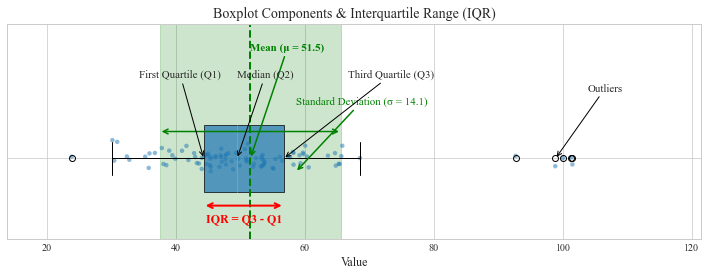

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Create a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Create synthetic data with a clear distribution and outliers
np.random.seed(42)
data = np.concatenate([
    np.random.normal(loc=50, scale=10, size=95),  # Main distribution
    np.random.normal(loc=100, scale=5, size=5)    # Outliers
])

# Calculate mean and standard deviation
mean_val = np.mean(data)
std_val = np.std(data)

# Create horizontal boxplot
box_elements = ax.boxplot(data, patch_artist=True, widths=0.5, vert=False)
box_elements['boxes'][0].set_facecolor('#1f77b4')
box_elements['boxes'][0].set_alpha(0.7)

# Add mean line in a distinct color
ax.axvline(x=mean_val, color='green', linestyle='--', linewidth=2)

# Plot standard deviation range
ax.axvspan(mean_val - std_val, mean_val + std_val, alpha=0.2, color='green')

# Scatter individual points with jitter
y = np.random.normal(1, 0.05, size=len(data))
ax.scatter(data, y, alpha=0.5, s=20, color='#1f77b4', edgecolor='none')

# Calculate quartiles for annotation
q1 = np.percentile(data, 25)
q2 = np.percentile(data, 50)  # median
q3 = np.percentile(data, 75)
iqr = q3 - q1

# Add annotations for mean and standard deviation
ax.annotate(f'Mean (μ = {mean_val:.1f})', xy=(mean_val, 1), xytext=(mean_val, 1.8),
             arrowprops=dict(arrowstyle='->', color='green', linewidth=1.5), 
             fontsize=11, color='green', fontweight='bold')

ax.annotate(f'Standard Deviation (σ = {std_val:.1f})', 
             xy=(mean_val + std_val/2, 0.9), 
             xytext=(mean_val + std_val/2, 1.4),
             arrowprops=dict(arrowstyle='->', color='green', linewidth=1.5), 
             fontsize=11, color='green')

# Add double-headed arrow for standard deviation range
ax.annotate('', xy=(mean_val - std_val, 1.2), xytext=(mean_val + std_val, 1.2),
            arrowprops=dict(arrowstyle='<->', color='green', linewidth=1.5))

# Add annotations for the parts of the boxplot
# Median line
ax.annotate('Median (Q2)', xy=(q2, 1), xytext=(q2, 1.6),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# Q1 annotation
ax.annotate('First Quartile (Q1)', xy=(q1, 1), xytext=(q1-10, 1.6),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# Q3 annotation
ax.annotate('Third Quartile (Q3)', xy=(q3, 1), xytext=(q3+10, 1.6),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# IQR annotation with arrow - positioned below the boxplot
ax.annotate('', xy=(q1, 0.65), xytext=(q3, 0.65),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text((q1+q3)/2, 0.55, 'IQR = Q3 - Q1', color='red', fontsize=12, 
        fontweight='bold', ha='center', va='center')

# Adjust the outliers annotation position
outliers = data[data > q3 + 1.5*iqr]
if len(outliers) > 0:
    ax.annotate('Outliers', xy=(outliers.mean(), 1), xytext=(outliers.mean()+5, 1.5),
                 arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)

# Add title and remove y-axis labels
ax.set_title('Boxplot Components & Interquartile Range (IQR)', fontsize=14)
ax.set_xlabel('Value', fontsize=12)
ax.set_yticklabels([''])

# Set appropriate x and y limits
x_min = min(data) - 10
x_max = max(data) + 20
ax.set_xlim(x_min, x_max)
ax.set_ylim(0.4, 2.0)

# # Add IQR description at the bottom
# desc_text = """
# Comparing Distributional Metrics:

# • IQR = Q3 - Q1: The middle 50% of data; robust to outliers
# • Mean (μ): The average of all values; affected by outliers
# • Standard Deviation (σ): Measures data spread around the mean
# • Median vs Mean: When different, indicates skewed distribution
# • IQR vs σ: Different approaches to measuring data variability
# """

# fig.text(0.5, 0.02, desc_text, ha='center', va='bottom', fontsize=11,
#          bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.8))

# Add main title
# fig.suptitle('Understanding Statistical Dispersion Metrics: IQR, Mean, and Standard Deviation', fontsize=16, y=0.97)

plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.savefig('iqr_boxplot_visualization.png', dpi=300, bbox_inches='tight')
plt.show()